# Исследование сервиса аренды самокатов GoFast

В нашем распоряжении данные сервиса аренды самокатов GoFast. Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Наша задача - проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.  
  
**Цель исследования:**  
1. Определить прибыль, которую приносят разные группы пользователей.
2. Установить, какие пользователи могут быть "выгоднее" для компании.
3. Проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.
  
**Ход исследования**  
Данные о пользователях мы получим из файла `'/datasets/users_go.csv'`, а данные о поездках - `'rides_go.csv'`. О качестве данных ничего не известно, поэтому перед исследованием понадобится обзор данных.  
Проверим данные на наличие пропусков и дубликатов. Далее создадим необходимые столбцы и приступим к проведению исследовательского анализа.  
Таким образом, наше исследование пройдет в семь этапов:  
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Объединение данных
- Подсчёт выручки
- Проверка гипотез
- Распределения

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt

### Шаг 1. Загрузка данных

Откроем датафреймы и изучим общую информацию, которую они содержат.

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv', sep=',')
data_rides = pd.read_csv('/datasets/rides_go.csv', sep=',')
data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv', sep=',')
data = [data_users, data_rides, data_subscriptions]

In [3]:
for i in data:
    display(i.head(10))

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В первом датафрейме содержится общая информация о пользователях: уникальный номер, имя, возраст, город и информация о наличии или отсутствии подписки.  
Во втором датафрейме содержится информация о поездках пользователей, по уникальному номеру можно соотнести первый и второй датафреймы.  
В третьем датафрейме содержится информация о стоимости поездок в зависимости от наличия подписки.

### Шаг 2. Предобработка данных

#### Изменение типа данных

In [4]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Заметим, что столбец date имеет тип object, приведем его к типу даты pandas.

In [5]:
data_rides['date'] = pd.to_datetime(data_rides['date'],
                                              format='%Y-%m-%d')

In [6]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Теперь всё верно!

Проверим за какой период содержатся данные о прокате.

In [7]:
print(data_rides['date'].min())
data_rides['date'].max()

2021-01-01 00:00:00


Timestamp('2021-12-30 00:00:00')

Здесь мы видим, что данные о прокате предоставлены только за 2021 год.

#### Новый столбец

На основе столбца date создадим новый столбец, который содержит только номер месяца.

In [8]:
data_rides['month'] = data_rides['date'].dt.month
data_rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


#### Проверка данных на наличие аномалий

In [9]:
print(data_rides['duration'].max())
data_rides['duration'].min()

40.82396261922424


0.5

Максимальное время аренды составляет почти 41 минута, ничего необычного. Минимальное время аренды пол минуты, скорее всего самокат оказался сломан, узнаем сколько таких значений.

In [10]:
data_rides.groupby('duration').agg({'user_id':'count'})

,user_id
duration,
0.500000,95
2.035632,1
2.053251,1
2.180879,1
2.222598,1
...,...
38.265229,1
38.352763,1
39.526602,1


Таких значений 95, можно просто избавится от этих поездок.

In [11]:
data_rides = data_rides[data_rides['duration'] > 0.5]

#### Избавление от пропущенных значений и дубликатов

Найдём и избавимся от пропущенных значений и дубликатов, если таковые имеются.

In [12]:
data_users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

В первом датафрейме пропущенных значений нет, отлично!

In [13]:
data_users.duplicated().sum()

31

А вот дубликаты присутствуют, избавимся от них:

In [14]:
data_users = data_users.drop_duplicates().reset_index(drop=True)
data_users.duplicated().sum()

0

Отлично, идем дальше.

In [15]:
print(data_rides.duplicated().sum())
data_rides.isna().sum()

0


user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Во втором датафрейме ни дубликатов, ни пропущенных значений нет.

Третий датафрейм можно не проверять, он содержит всего 2 строки и это данные о стоимости тарифов.

### Шаг 3. Исследовательский анализ данных

Постараемся описать и визуализировать общую информацию о пользователях и поездках:

#### Частота встречаемости городов

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

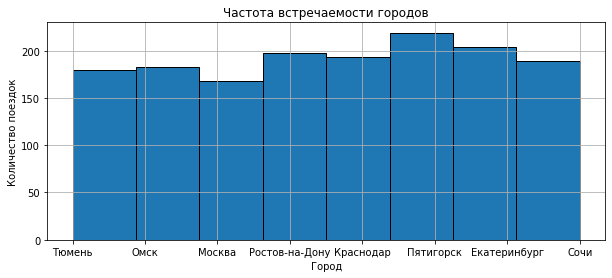

In [16]:
ax = plt.figure(figsize=(10,4)).gca()
data_users['city'].hist(bins=8, ax=ax, edgecolor='black')
plt.title("Частота встречаемости городов")
plt.xlabel("Город")
plt.ylabel("Количество поездок")
data_users['city'].value_counts()

По графику видно, что в нашей выборке пользователи совершили больше всего поездок в Пятигорске, а меньше всего в Москве.

#### Соотношение пользователей с подпиской и без подписки

free     835
ultra    699
Name: subscription_type, dtype: int64


1.1945636623748213

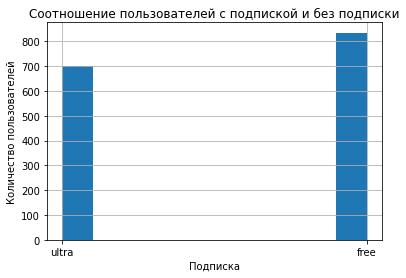

In [17]:
data_users['subscription_type'].hist()
plt.title("Соотношение пользователей с подпиской и без подписки")
plt.xlabel("Подписка")
plt.ylabel("Количество пользователей")
print(data_users['subscription_type'].value_counts())
len(data_users[data_users['subscription_type']=='free']) / len(data_users[data_users['subscription_type']=='ultra'])

Как мы видим, пользователей без подписки всего в 1,2 раза больше, разница совсем небольшая.

#### Соотношение возраста пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

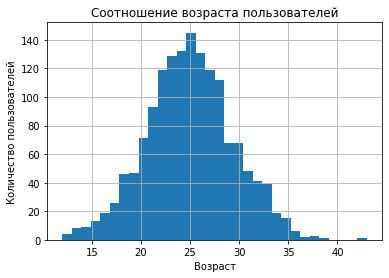

In [18]:
data_users['age'].hist(bins=32)
plt.title("Соотношение возраста пользователей")
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
data_users['age'].describe()

Заметим, что распределение возраста пользователей напоминает нормальное распределение, медина и среднее практически равны между собой, что составляет 25 лет.

#### Расстояние, которое пользователь преодолел за одну поездку

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

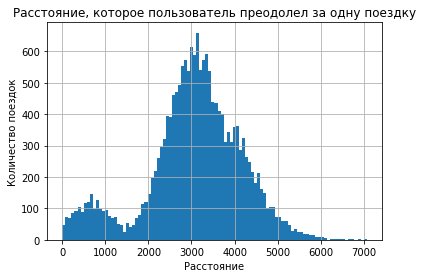

In [19]:
data_rides['distance'].hist(bins=100)
plt.title("Расстояние, которое пользователь преодолел за одну поездку")
plt.xlabel("Расстояние")
plt.ylabel("Количество поездок")
data_rides['distance'].describe()

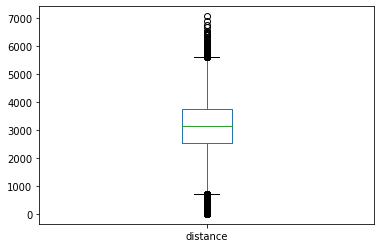

In [20]:
ax=data_rides['distance'].plot.box()
plt.show()

В среднем пользователь проезжает 3 км, но наблюдается небольшой пик в начале, интересно с чем же это связано.

#### Продолжительность поездок

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

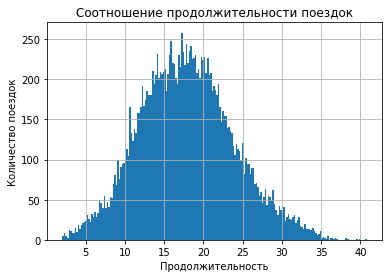

In [21]:
data_rides['duration'].hist(bins=200)
plt.title("Соотношение продолжительности поездок")
plt.xlabel("Продолжительность")
plt.ylabel("Количество поездок")
data_rides['duration'].describe()

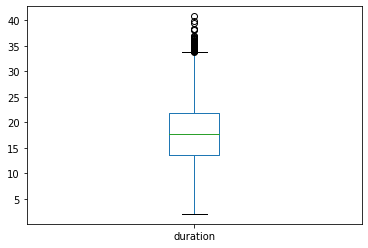

In [22]:
ax=data_rides['duration'].plot.box()
plt.show()

Средняя продолжительность сессии составляет почти 18 минут.

### Шаг 4. Объединение данных

#### Объединим данные о пользователях, поездках и подписках в один датафрейм

Перед тем как объединять датафреймы проверим их размерность:

In [23]:
data_users.info()
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 842.5 KB


1534 строки с данными о пользователях и 17973 строки с данными о поездках.

Объединим данные о пользователях, поездках и подписках в один датафрейм:

In [24]:
big_data = data_users.merge(data_rides, on='user_id') # аргумент how по умлочанию 'inner', что значит пересечение данных
big_data.sample(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month
10182,972,Анна,16,Сочи,free,1227.501766,16.603132,2021-10-22,10
15886,1387,Борис,27,Москва,free,4041.329925,18.154987,2021-02-17,2
6431,692,Денис,21,Сочи,ultra,3300.363169,18.901090,2021-02-01,2
12135,1115,Анна,29,Екатеринбург,free,3640.676705,29.803123,2021-08-23,8
8943,884,Александра,20,Москва,free,3861.523645,15.073540,2021-07-01,7
12350,1132,Наталия,20,Москва,free,3713.113060,22.568722,2021-03-23,3
4287,461,Яромир,20,Пятигорск,ultra,980.349369,5.100749,2021-12-13,12
1742,188,Жанна,21,Сочи,ultra,3009.395034,10.850596,2021-10-14,10
10194,973,Александр,27,Омск,free,2909.323026,19.468527,2021-10-15,10
15910,1389,Виолетта,25,Омск,free,2186.678299,16.288928,2021-01-20,1


Проверим размерность полученного датафрейма:

In [25]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


17973 строки, всё верно, данные по каждой поездке вошли в общий датафрейм.

#### Создадим ещё два датафрейма с данными о пользователях с подпиской (ultra) и без подписки (free)

In [26]:
users_free = big_data[big_data['subscription_type']=='free']
users_free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11473 entries, 6500 to 17972
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11473 non-null  int64         
 1   name               11473 non-null  object        
 2   age                11473 non-null  int64         
 3   city               11473 non-null  object        
 4   subscription_type  11473 non-null  object        
 5   distance           11473 non-null  float64       
 6   duration           11473 non-null  float64       
 7   date               11473 non-null  datetime64[ns]
 8   month              11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 896.3+ KB


In [27]:
users_ultra = big_data[big_data['subscription_type']=='ultra']
users_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 507.8+ KB


Сразу можно заметить, что поездок без подписки почти в 2 раза больше.

#### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

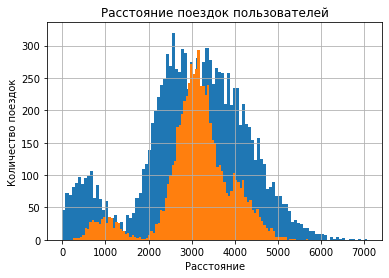

In [28]:
users_free['distance'].hist(bins=100)
users_ultra['distance'].hist(bins=100)

plt.title("Расстояние поездок пользователей")
plt.xlabel("Расстояние")
plt.ylabel("Количество поездок")

print(users_free['distance'].describe())
users_ultra['distance'].describe()

Поездки пользователей с подпиской оранжевого цвета

Медианы практически равны и распределения имеют схожую форму, но у пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей.

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64


count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

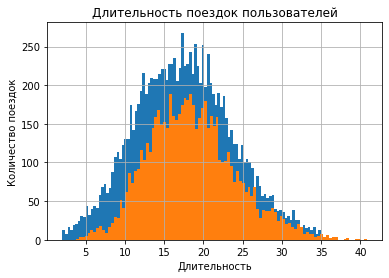

In [29]:
users_free['duration'].hist(bins=100)
users_ultra['duration'].hist(bins=100)

plt.title("Длительность поездок пользователей")
plt.xlabel("Длительность")
plt.ylabel("Количество поездок")

print(users_free['duration'].describe())
users_ultra['duration'].describe()

Можно сделать вывод, что поведения пользователей с подпиской и без неё очень схожи, но в каждом из диапазонов бесплатных пользователей чуть больше, но их, как мы помним, и в целом больше.

### Шаг 5. Подсчёт выручки

In [30]:
big_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64

В сводной таблице нет пропусков. Выведем её на экран:

In [31]:
big_data[big_data['user_id'] > 698].head(13)

,user_id,name,age,city,subscription_type,distance,duration,date,month
6492,699,Оксана,22,Москва,ultra,3433.522627,19.734091,2021-03-29,3
6493,699,Оксана,22,Москва,ultra,4072.797406,16.575991,2021-06-02,6
6494,699,Оксана,22,Москва,ultra,3045.277646,19.610605,2021-08-25,8
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10
6499,699,Оксана,22,Москва,ultra,3202.890770,25.217345,2021-12-03,12
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2


Заметим, что начиная с 700 пользователя начинаются пользователи без подписки.

#### Найдём суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [32]:
users_by_month = big_data.groupby(['user_id', 'month']).agg({'distance':'sum',
                                                             'duration':'sum',
                                                             'name':'count'})
users_by_month.columns=['distance', 'duration', 'count']
users_by_month.head(13)

distance   duration  count
user_id month                                
1       1       7027.511294  41.416640      2
        4        754.159807   6.232113      1
        8       6723.470560  44.776802      2
        10      5809.911100  31.578017      2
        11      7003.499363  53.397424      3
        12      6751.629942  27.203912      2
2       3      10187.723006  60.959959      3
        4       6164.381824  39.048633      2
        6       3255.338202  13.851127      1
        7       6780.722964  46.170157      2
        8        923.007439   6.914760      1
        10      2824.636598  18.779128      1
        12      3828.248580  11.920514      1

#### Вычислим помесячную выручку, которую принёс каждый пользователь

In [33]:
users_by_month = users_by_month.reset_index() #Сбросим индексы

Перед агрегацией продолжительность поездки должна быьб округлена в большую сторону:

In [34]:
users_by_month['duration'] = np.ceil(users_by_month['duration'])

Зная, что с 700 пользователя находятся пользователи без подписки, рассчитаем прибыль каждого пользователя.

In [35]:
first_free_user_id = 700

In [36]:
users_by_month.loc[users_by_month['user_id'] < first_free_user_id, 'profit'] =\
    users_by_month['duration']*6 + 199
users_by_month.loc[users_by_month['user_id'] >= first_free_user_id, 'profit'] =\
    users_by_month['duration']*8 + users_by_month['count']*50

In [37]:
users_by_month.head(13)

,user_id,month,distance,duration,count,profit
0,1,1,7027.511294,42.0,2,451.0
1,1,4,754.159807,7.0,1,241.0
2,1,8,6723.470560,45.0,2,469.0
3,1,10,5809.911100,32.0,2,391.0
4,1,11,7003.499363,54.0,3,523.0
5,1,12,6751.629942,28.0,2,367.0
6,2,3,10187.723006,61.0,3,565.0
7,2,4,6164.381824,40.0,2,439.0
8,2,6,3255.338202,14.0,1,283.0
9,2,7,6780.722964,47.0,2,481.0


Рассчитанная выручка пригодится нам при дальнейшем анализе.

### Шаг 6. Проверка гипотез

#### Проверим, тратят ли пользователи с подпиской больше времени на поездки

Проведем односторонний t-тест для сравнения средних двух выборок.  
*Нулевая гипотеза:* время, которое тратят пользователи с подпиской равно времени, которое тратят на поездки пользователи без подписки.  
*Альтернативная гипотеза:* среднее значение времени, которое тратят пользователи с подпиской больше среднего значения времени, которое тратят на поездки пользователи без подписки.  
Выборки разного размера и мы не уверены в равенстве их дисперсий, поэтому equal_var=False.

In [38]:
result = st.ttest_ind(users_ultra['duration'],
                      users_free['duration'],
                      equal_var=False,
                      alternative='greater')
print('p-значение:', result.pvalue)
if result.pvalue < 0.01:
    print('Отвергаем гипотезу о равенстве средних в пользу альтернативной гипотезы')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.6162210195311063e-29
Отвергаем гипотезу о равенстве средних в пользу альтернативной гипотезы


Не важно какой уровень статистической значимости 1% или 5%, p-значение крайне мало, а это значит что, *пользователи, у которых есть подписка, действительно тратят в среднем больше времени на поездки.*

#### Узнаем какое расстояние проезжают пользователи с подпиской

Проведем односторонний t-тест с правосторонней альтернативной гипотезой.  
*Нулевая гипотеза:* среднее растояние, которое проезжают пользователи с подпиской равно 3130 метров.  
*Альтернативная гипотеза:* среднее растояние, которое проезжают пользователи с подпиской больше 3130 метров.

In [39]:
result = st.ttest_1samp(users_ultra['distance'],
                      3130,
                      alternative='greater')
print('p-значение:', result.pvalue)
if result.pvalue < 0.05:
    print('Отвергаем гипотезу о равенстве средних')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


T-тест показал, что *среднее расстояние, которое проезжают пользователи с подпиской не превышает 3130 метров.*

#### Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Проведем односторонний t-тест для сравнения средних двух выборок.  
Нулевая гипотеза: выручка от пользователей с подпиской  равно выручке от пользователей без подписки.  
Альтернативная гипотеза: выручка от пользователей с подпиской больше выручки от пользователей без подписки.  
Выборки разного размера и мы не уверены в равенстве их дисперсий, поэтому equal_var=False.

In [40]:
profit_free = users_by_month[users_by_month['user_id'] >= 700]
profit_free = profit_free['profit']

In [41]:
profit_ultra = users_by_month[users_by_month['user_id'] < 700]
profit_ultra = profit_ultra['profit']

In [42]:
result = st.ttest_ind(profit_ultra,
                      profit_free,
                      equal_var=False,
                      alternative='greater')
print('p-значение:', result.pvalue)
if result.pvalue < 0.01:
    print('Отвергаем гипотезу о равенстве средних в пользу альтернативной гипотезы')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.358240071530384e-43
Отвергаем гипотезу о равенстве средних в пользу альтернативной гипотезы


T-тест показал, что в среднем выручка от пользователей с подпиской выше выручки от пользователей без подписки, получается, что пользователи с подпиской "выгоднее" для компании.

#### Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для проверки данной гипотезы необходимо провести t-тест на равенство средних для двух зависимых выборок, первая выборка - количество обращений каждого пользователя до обновления, вторая выборка - количество обращений каждого пользователя после обновления.  
Нулевая гипотеза: средние генеральных совокупностей равны.  
Альтернативная гипотеза: среднее значение обращений до обновления больше среднего значения обращений после обновления.  
Код выглядел бы примерно так: result = st.ttest_rel(array1, array2, alternative='greater')  
Если p-value получилось бы меньше 5%, то всё хорошо, нулевая гипотеза отвергнута в пользу альтернативной, кол-во обращений действительно снизилось.  
Если p-value получилось бы больше 5%, то это значит, что кол-во обращений не уменьшилось и технической команде нужно ещё поработать над обновлением.

### Шаг 7. Распределения

#### Проведем акцию и узнаем какое кол-во промокодов нужно разослать, чтобы с вероятностью 95% при вероятности оформления подписки в 10% после бесплатного пробного периода 100 клиентов продлили подписку.

В данном случае у нас биномиальное распределение, клиент либо оформит подписку, либо нет.  
Будем менять число n (кол-во промокодов) так, чтобы вероятность не выполнить план была примерно 5%

In [43]:
n = 1169 #кол-во экспериментов
p = 0.1 #вероятность, что клиент оставит подписку
mu = n * p #мат. ожидание
sigma = sqrt(n * p * (1-p)) #стандартное отклонение
distr = st.norm(mu, sigma) #первый аргумент - мат. ожидание, второй - стандартное отклонение

x = 100 #число клиентов, которое хотим заполучить

distr.cdf(x) #вероятность того, что кол-во клиентов, продливших подписку окажется меньше x

0.04971489312694162

Построим график распределения:

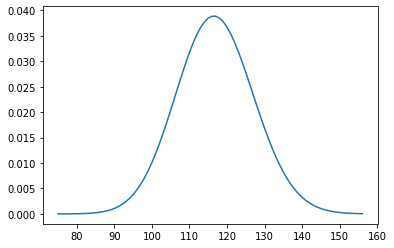

In [44]:
n = 1169 #задаём параметры биномиального распределения
p = 0.1

left = int(n * p - 4 * sqrt(n * p * (1 - p))) #задаём границы промежутка
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(left, right))
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p));

Таким образом, необходимо разослать 1169 промокодов, чтобы больше 100 клиентов продлили подписку с вероятностью 95%.

#### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40% получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построим примерный график распределения и оценим вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

В данном случае мы снова имеет дело с биномиальным распределением.

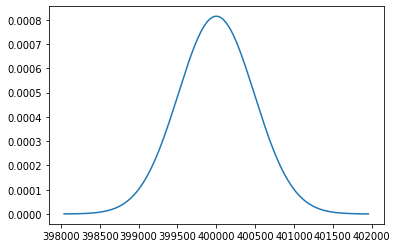

In [45]:
n = 1000000 #задаём параметры биномиального распределения
p = 0.4

left = int(n * p - 4 * sqrt(n * p * (1 - p))) #задаём границы промежутка
right = int(n * p + 4 * sqrt(n * p * (1 - p)))

x = list(range(left, right))
ax = plt.subplot()
ax.plot(x, binom.pmf(x, n, p));

In [46]:
n = 1000000 #кол-во экспериментов
p = 0.4 #вероятность, что клиент откроет уведомление
mu = n * p #мат. ожидание
sigma = sqrt(n * p * (1-p)) #стандартное отклонение
distr = st.norm(mu, sigma) #первый аргумент - мат. ожидание, второй - стандартное отклонение

x = 399500

distr.cdf(x) #вероятность того, что кол-во клиентов, открывших уведомление окажется меньше x

0.15371708296369768

Таким образом, вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равняется примерно 15%

### Общий вывод

В данной работе у нас стояла задача проанализировать данные и проверить некоторые гипотезы, которые помогли бы бизнесу вырасти.

При предобработке данных, были исключены аномалии и дубликаты.
Далее мы приступили к анализу полученных данных, для описания данных были использованы гистограммы (метод hist()), боксплоты (метод plot.box()).

Далее был создан датафрейм с агрегированными данными и рассчитана помесячная выручка, которую принёс каждый пользователь.

Затем мы приступили к проверке гипотез. В ходе исследования было проведено несколько t-тестов и были выявлены следующие зависимости:  
- пользователи, у которых есть подписка, тратят в среднем больше времени на поездки, 
- расстояние, которое проезжают пользователи с подпиской за одну поездку, в среднем не превышает 3130 метров,  
- в среднем выручка от пользователей с подпиской выше выручки от пользователей без подписки,  
  
В конце было проведено ещё несколько исследований для отдела маркетинга. Выяснилось, что необходимо разослать 1169 промокодов, чтобы с вероятностью 95% больше 100 клиентов продлили подписку. А также, если отдел планирует разослать 1 млн уведомлений, то с вероятностью 15% уведомление откроют не более 399,5 тыс. пользователей.  

В заключение можно сказать, что компания может смело привлекать новых клиентов и стараться сделать так, чтобы пользователи оформляли подписку. Так выручка компании может вырасти и бизнес выйдет на новый уровень.